In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import datasets
from tqdm.auto import tqdm

In [2]:
# c4_data = datasets.load_dataset("../data/tencent-compounds-emb", name="tencent-c4")
c2_data = datasets.load_dataset("../data/tencent-compounds-emb", name="tencent-c2")
c2_data = c2_data.remove_columns(["compound_text", "const1_text", "const2_text"])
c2_data = c2_data.with_format("torch")

Using custom data configuration tencent-c2
Found cached dataset tencent-compounds-emb (/Users/seantyh/.cache/huggingface/datasets/tencent-compounds-emb/tencent-c2/0.0.0/9b82dbd5d5f70e31abd2ff5af93b8071eb828c405a5d931356c83e2ee0b3fc26)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import psutil, os
proc = psutil.Process(os.getpid())
proc.memory_info().rss/1024**2

251.671875

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
class CompoundEps(nn.Module):
  def __init__(self, emb_dim, h_dim=800, dropout=0.1):
    super().__init__()
    in_dim = emb_dim*2
    out_dim = emb_dim
    self.lin_proj = nn.Parameter(torch.randn(in_dim, out_dim))
    self.fc_mod = nn.Sequential(
      nn.Linear(in_dim, h_dim),
      nn.Tanh(),
      nn.Dropout(dropout),
      nn.Linear(h_dim, out_dim),
      nn.Tanh()
    )

  def forward(self, x, true_vecs=None):
    lin = torch.matmul(x, self.lin_proj)
    eps = self.fc_mod(x)
    pred = lin+eps
    if true_vecs is not None:
      loss = F.mse_loss(pred, true_vecs)
      return pred, loss
    return pred

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(c2_data["train"], batch_size=16, shuffle=False)
val_loader = DataLoader(c2_data["validation"], batch_size=16, shuffle=False)
test_loader = DataLoader(c2_data["test"], batch_size=16, shuffle=False)

In [16]:
model = CompoundEps(200)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
loss_vec = []
for epoch_i in tqdm(range(100)):
  for batch in train_loader:
    optimizer.zero_grad()
    consts = batch["consts"]
    compound = batch["compound"]
    pred, loss = model(consts, compound)
    loss.backward()
    optimizer.step()
    loss_vec.append(loss.item())
    break


  0%|          | 0/100 [00:00<?, ?it/s]

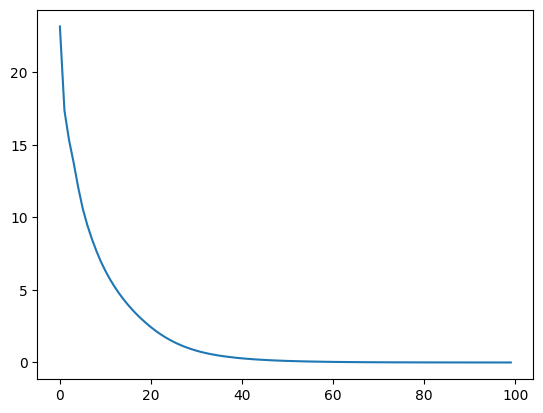

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_vec)